# Convolutional Neural Networks for Semantic Segmentation

There are a number of pre-trained CNNs that may be used to detect a particular objects, such as trucks, in the scene.
Once the object of interest has been spotted, we can focus detection on that area.

Using the model from https://gist.github.com/shelhamer/91eece041c19ff8968ee
Using label number=>name mapping from http://www.cs.stanford.edu/~roozbeh/pascal-context/ (59_labels.txt)


# Preparation

## Setup

* First, set up Python, `numpy`, and `matplotlib`.

In [7]:
# set up Python environment: numpy for numerical routines, and matplotlib for plotting
import numpy as np
import matplotlib.pyplot as plt
# display plots in this notebook
%matplotlib inline

# set display defaults
plt.rcParams['figure.figsize'] = (10, 10)        # large images
plt.rcParams['image.interpolation'] = 'nearest'  # don't interpolate: show square pixels
plt.rcParams['image.cmap'] = 'gray'  # use grayscale output rather than a (potentially misleading) color heatmap

* Load `caffe`.

In [8]:
# The caffe module needs to be on the Python path;
#  we'll add it here explicitly.
import os
import sys
caffe_root = '/opt/caffe/'  # this file should be run from {caffe_root}/examples (otherwise change this line)
sys.path.insert(0, caffe_root + 'python')

import caffe
# If you get "No module named _caffe", either you have not built pycaffe or you have the wrong path.

## Load net and set up input preprocessing

* Set Caffe to CPU mode and load the net from disk.

* The files are system-wide available on arc.insight.gsu.edu 

https://github.com/developmentseed/caffe-fcn/tree/master/fcn-8s
Download http://dl.caffe.berkeleyvision.org/fcn-8s-pascalcontext.caffemodel

In [9]:
caffe.set_mode_cpu()

net_root = caffe_root+'/caffe-fcn/fcn-8s'

model_def = net_root + '/deploy.prototxt'
model_weights = net_root + '/fcn-8s-pascalcontext.caffemodel'

net = caffe.Net(model_def,      # defines the structure of the model
                model_weights,  # contains the trained weights
                caffe.TEST)     # use test mode (e.g., don't perform dropout)

* Set up input preprocessing.

  The input is expected in BGR channel order, with the following per-channel mean subtracted:
  B 104.00698793 G 116.66876762 R 122.67891434
  
    As matplotlib will load images with values in the range [0, 1] in RGB format with the channel as the _innermost_ dimension, we are arranging for the needed transformations here.

In [10]:
mu = np.array([104.00698793, 116.66876762, 122.67891434])
print 'mean values:', zip('BGR', mu)

# create transformer for the input called 'data'
transformer = caffe.io.Transformer({'data': net.blobs['data'].data.shape})

transformer.set_transpose('data', (2,0,1))  # move image channels to outermost dimension
transformer.set_mean('data', mu)            # subtract the dataset-mean value in each channel
transformer.set_raw_scale('data', 255)      # rescale from [0, 1] to [0, 255]
transformer.set_channel_swap('data', (2,1,0))  # swap channels from RGB to BGR

mean values: [('B', 104.00698792999999), ('G', 116.66876762), ('R', 122.67891434000001)]


# Segmentation

* Load an image (that comes with Caffe) and perform the preprocessing we've set up.

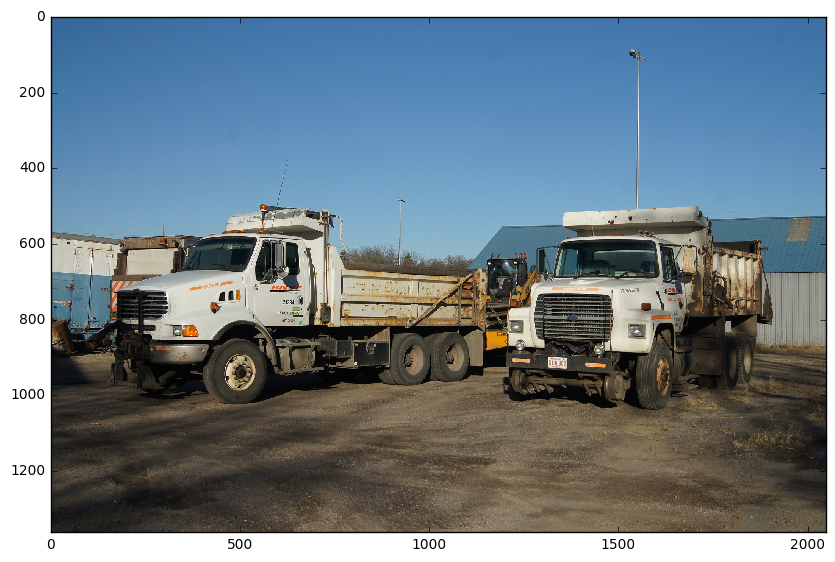

In [11]:
#image = caffe.io.load_image('caffe-fcn/images/cat.jpg')
##image = caffe.io.load_image('data/Ticket 394850/235734-b.jpg')
image = caffe.io.load_image('trucks.jpg')
#image = caffe.io.load_image('../data/pascal-voc2010/JPEGImages/2007_000241.jpg')
transformed_image = transformer.preprocess('data', image)
plt.imshow(image)
# copy the image data into the memory allocated for the net
net.blobs['data'].data[...] = transformed_image

In [12]:
### perform classification
output = net.forward()

score = output['score'][0]  # the output probability vector for the first image in the batch

print output['score'].shape

(1, 60, 500, 500)


In [13]:
net.top_names

OrderedDict([('input', ['data']),
             ('data_input_0_split',
              ['data_input_0_split_0', 'data_input_0_split_1']),
             ('conv1_1', ['conv1_1']),
             ('relu1_1', ['conv1_1']),
             ('conv1_2', ['conv1_2']),
             ('relu1_2', ['conv1_2']),
             ('pool1', ['pool1']),
             ('conv2_1', ['conv2_1']),
             ('relu2_1', ['conv2_1']),
             ('conv2_2', ['conv2_2']),
             ('relu2_2', ['conv2_2']),
             ('pool2', ['pool2']),
             ('conv3_1', ['conv3_1']),
             ('relu3_1', ['conv3_1']),
             ('conv3_2', ['conv3_2']),
             ('relu3_2', ['conv3_2']),
             ('conv3_3', ['conv3_3']),
             ('relu3_3', ['conv3_3']),
             ('pool3', ['pool3']),
             ('pool3_pool3_0_split',
              ['pool3_pool3_0_split_0', 'pool3_pool3_0_split_1']),
             ('conv4_1', ['conv4_1']),
             ('relu4_1', ['conv4_1']),
             ('conv4_2', ['conv4

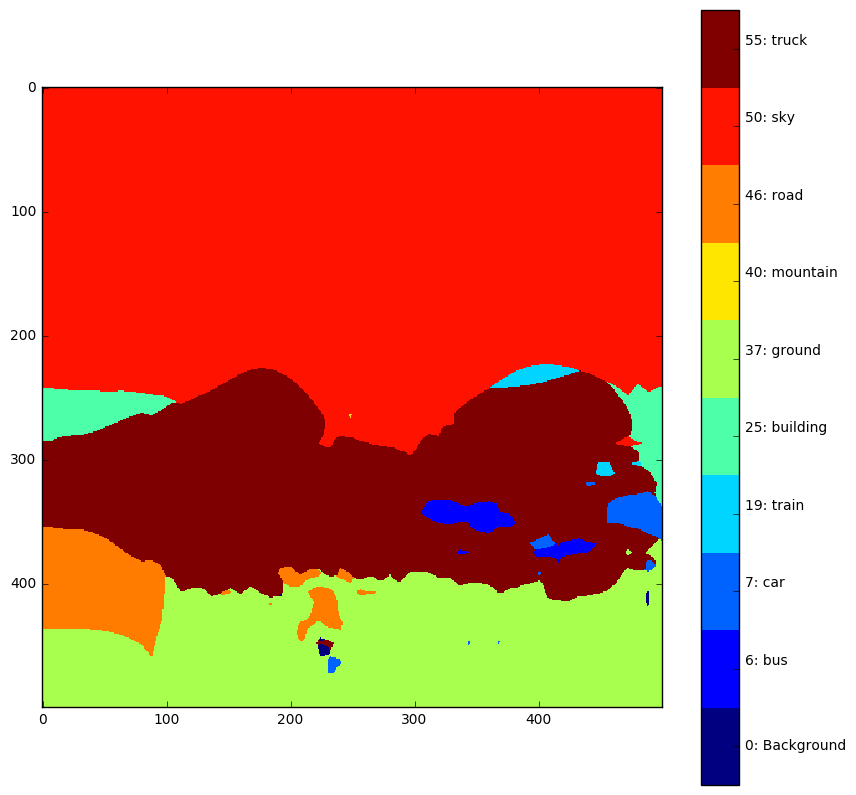

In [14]:
classed = np.argmax(score, axis=0)

names = dict()
all_labels = ["0: Background"] + open(net_root + '/legend.txt').readlines()
scores = np.unique(classed)
labels = [all_labels[s] for s in scores]
num_scores = len(scores)

def rescore (c):
    """ rescore values from original score values (0-59) to values ranging from 0 to num_scores-1 """
    return np.where(scores == c)[0][0]
rescore = np.vectorize(rescore)

painted = rescore(classed)

plt.figure(figsize=(10, 10))
plt.imshow(painted, cmap=plt.cm.get_cmap('jet', num_scores))

# setup legend
formatter = plt.FuncFormatter(lambda val, loc: labels[val])
plt.colorbar(ticks=range(0, num_scores), format=formatter)
plt.clim(-0.5, num_scores - 0.5)
plt.savefig('output.jpg')

# Run on Video Frames

In [37]:
from IPython.display import display

In [ ]:
#def rescore (c):
#    """ rescore values from original score values (0-59) to values ranging from 0 to num_scores-1 """
#    return np.where(scores == c)[0][0]


In [ ]:
frames = [ f[:-1] for f in os.popen('ls videoframes/*.jpg').readlines() ]
for fr in frames:
    print fr
    image = caffe.io.load_image(fr)
    transformed_image = transformer.preprocess('data', image)
    net.blobs['data'].data[...] = transformed_image
    output = net.forward()
    score = output['score'][0]  # the output probability vector for the first image in the batch
    classed = np.argmax(score, axis=0)
    names = dict()
    all_labels = ["0: Background"] + open(net_root + '/legend.txt').readlines()
    scores = np.unique(classed)
    labels = [all_labels[s] for s in scores]
    num_scores = len(scores)
    rescore = np.vectorize(rescore)
    painted = rescore(classed)

    plt.figure(figsize=(10, 5))
    plt.subplot(1,2,1)
    plt.imshow(image)
    plt.subplot(1,2,2)
    plt.imshow(painted, cmap=plt.cm.get_cmap('jet', num_scores))

    # setup legend
    formatter = plt.FuncFormatter(lambda val, loc: labels[val])
    plt.colorbar(ticks=range(0, num_scores), format=formatter)
    plt.clim(-0.5, num_scores - 0.5)
    

videoframes/30_2016-07-20_123601_N0001.jpg
videoframes/30_2016-07-20_123601_N0002.jpg
videoframes/30_2016-07-20_123601_N0003.jpg
videoframes/30_2016-07-20_123601_N0004.jpg
videoframes/30_2016-07-20_123601_N0005.jpg
videoframes/30_2016-07-20_123601_N0006.jpg
